# Populations of LIF neurons

In [1]:
import numpy as np
import random 
import time
import nest
import pylab
import nest.raster_plot
import matplotlib.pyplot as plt
nest.ResetKernel()

We want a system to create a population of connected neurons. We want to set all the parameters of a group in the same way, not feasible to create one neuron at a time with its own parameters. How can we do that?

In [2]:
ndict = {"I_e": 200.0, "tau_m": 20.0}
neuronpop = nest.Create("iaf_psc_alpha", 100, params=ndict)

#We just created 100 LIF neurons. 
#We can define their parameters using params= dictionary with the parameters we want to set 

Create now 2 populations. One population with 150 neurons, the second with 100 neurons. 
The first populations should have I_e= 300 and tau_m= 20.0 while the second population should have 
I_e= 200 and tau_m= 10.0.

In [3]:
#Answer:


How can we connect two populations? Do we want all the neurons to be connected? Only a part of them? This is part of the modeler choice! Let's explore some options:

In [5]:
pop1=nest.Create("iaf_psc_alpha", 10)
pop2=nest.Create("iaf_psc_alpha", 10)
nest.Connect(pop1, pop2,'all_to_all', syn_spec={"weight":20.0})
#Each neuron of pop1 is connected to every neuron in pop2.
#How many connections do we have in total in this example?
#Answer:

Alternatively, the neurons can be connected with the one_to_one rule. This means that the first neuron in pop1 is connected to the first neuron in pop2, the second to the second, etc., creating ten connections in total.

In [6]:
nest.Connect(pop1, pop2, "one_to_one", syn_spec={"weight":20.0})

Here we have just used very simple connection schemes. Connectivity patterns requiring the specification of further parameters, such as in-degree or connection probabilities, must be defined in a dictionary containing the key rule and the key for parameters associated to the rule. Have a look here to see more complex connection rules:
https://nest-simulator.readthedocs.io/en/stable/guides/connection_management.html#all-to-all

Then choose one and create your own network of two populations with the connection rule you prefer!


In [7]:
#Answer:


# Analyse 1 big population of connected neurons. 

We will now create one network of LIF neurons and look at the results of the simulation.

In [123]:
nest.ResetKernel()

In [124]:
dt = 1.0  # the resolution in ms
t_sim = 1000.0  # Simulation time in ms

Create a populations of 100 neurons with "I_e": 190.0, "tau_m": 20.0

In [125]:
#Answer:

Connect all the neurons in the population with the "all_to_all rule" and a weight=5.

In [127]:
#Answer:

In [129]:
#Create the spike recorder 
spikes = nest.Create("spike_recorder") 
N_rec=10
#Connect pop with spike recorders
nest.Connect(NAME_OF_YOUR_POPULATION[:N_rec], spikes) 

#Create the multimeter to record the membrane potential
multimeter=nest.Create('multimeter', N_rec) # I record from just N_rec neurons (not all)
multimeter.set(record_from=["V_m"])
#Connect pop with multimeter
nest.Connect(multimeter, NAME_OF_YOUR_POPULATION[:N_rec])

In [130]:
#Simulate the network for a given time
start = time.time()
nest.Simulate(t_sim)
end = time.time()

Simulate the network
Number of neurons : 100
FR of the population   : 16.00 Hz


<Figure size 432x288 with 0 Axes>

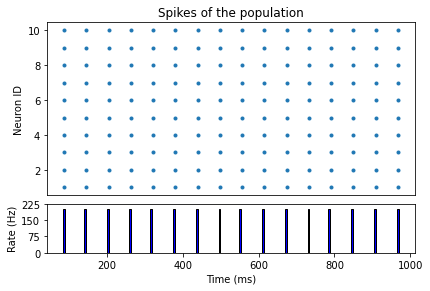

In [131]:
#RESULTS OF THE SIMULATION
events=nest.GetStatus(spikes[:N_rec],'n_events')[0] #to count the number of spikes from N_rec neurons
rate = (events / (t_sim *N_rec))* 1000.0 #Compute the mean firing rate for the population

print("Time of the simulation:",end-start)
print("Simulate the network")
print("Number of neurons : {0}".format(N_neurons))
print("FR of the population   : %.2f Hz" % rate)

#Raster plot
pylab.figure(1)
nest.raster_plot.from_device(spikes, hist=True)
pylab.title('Spikes of the population')
#pylab.savefig('Exit_rast_hist_nest30.png')
plt.show()

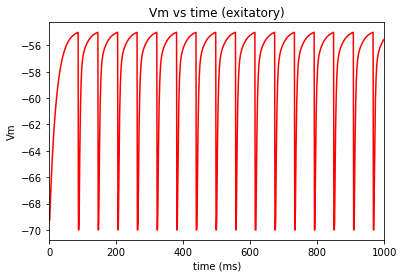

In [132]:
#We want to plot the membrane potential evolution of the neurons
dmm=nest.GetStatus(multimeter)[0] #the index 0 allow me to then visualize neuron 0, if you put 9 you observe neuron 9
Vms_e=dmm['events']["V_m"][::N_rec]# first index until the end ::
#After each 10 values I have the next V (at next time step) for that neuron 
#For each step i record 10 neurons
#If I don't put 10 I have the 10 values of V for each step (because I record from 10 neurons)
ts_e=dmm['events']['times'][::N_rec] #Same reasoning as before

#Plot the figure for Vm for 1 neuron
pylab.figure(1)
pylab.plot(ts_e,Vms_e, color='r')
pylab.title('Vm vs time (exitatory)')
pylab.xlim(0,1000)
#pylab.xlim(0,200)
pylab.xlabel('time (ms)')
pylab.ylabel('Vm')
#pylab.savefig('memb_params.png')
pylab.show()

What happens when we increase the input to the neurons? How the mean FR is changing? \
Change the value I_e and run again the code to answer. (remember to run from the cell nest.ResetKernel())

In [134]:
#Answer:

Put I_e back to 190. 
What happens now if we increase the weight between the neurons? How the mean FR is changing? \
Change the value "weight" and run again the code to answer. (remember to run from the cell nest.ResetKernel()) \
Why do you think this is happening?

In [ ]:
#Answer:

Try to increase significantly the nymber of neurons. How is the time of the simulation affected? Reflect on this.

In [ ]:
#Answer:

How can we simulate a really big network? Do you know High performance computers (HPC)?

In [ ]:
#Answer:

# Complex example: 2 interacting populations. 

Now that we are familiar with Nest let's look at a more complex example where we have two populations: 
one excitatory and one inhibitory. Each population has its own parameter values. Let's study the how the two populations interact.

Fisrt try to understand every step of the code, ask me for help if you don't understand something. Later you will need to change some part of the code to be able to answer the questions and study the network behavior.

In [145]:
nest.ResetKernel()
startbuild = time.time() #to time the building time of the network

dt = 1.0  # the resolution in ms
t_sim = 1000.0  # Simulation time in ms
delay = 0.5  # synaptic delay in ms

nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

epsilon = 0.1  # connection probability

order = 1000 
Ne = int(0.8 * order)  # number of excitatory neurons
Ni = int(0.2 * order)  # number of inhibitory neurons
N_neurons = Ne + Ni  # number of neurons in total
N_rec = 50  # record from 50 neurons

CE = int(epsilon * Ne)  # number of excitatory synapses per neuron
CI = int(epsilon * Ni)  # number of inhibitory synapses per neuron
#C_tot = int(CI + CE)  # total number of synapses per neuron

tau_e = 20.0  #ms time constant of membrane potential for exitatory
tau_i = 10.0  #ms time constant of membrane potential for inhibitory
theta = 15.0  #mV membrane threshold potential 
Cm_e=500 #pF capacitance of the membrane for excitatory neurons
Cm_i=200 #pF capacitance of the membrane for excitatory neurons

ex_params = {"C_m": Cm_e,
                 "tau_m": tau_e,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "I_e": 0.0,
                 "V_th": theta}

in_params = {"C_m": Cm_i, 
                 "tau_m": tau_i,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m":0.0,
                 "I_e": 0.0,
                 "V_th": theta}

print("Building network")
#I am creating the network
pop_e=nest.Create('iaf_psc_delta',Ne, params=ex_params) #Build the Excitatory pop, Ne neurons, with params set before
pop_i=nest.Create('iaf_psc_delta',Ni, params=in_params)  #Build the Inhib pop, Ni neurons, with params set before

#Weights I will use between the 2 populatons:
Jee = 0.6  #to e from e # amplitude of postsynaptic potential (in mV)
Jie= 0.1  #to i from e
Jii= -0.2 # to i from i
Jei= -0.01 #to e from i

#connections values between populations I will use when connecting
syn_dict_ie={'delay':delay, 'weight': Jie} 
syn_dict_ee={'delay':delay, 'weight': Jee} 
syn_dict_ei={'delay':delay, 'weight': Jei}
syn_dict_ii={'delay':delay, 'weight': Jii}

#Rules of connections I am using
conn_dict_ex = {'rule': 'fixed_indegree', 'indegree': CE}
conn_dict_in = {'rule': 'fixed_indegree', 'indegree': CI}

print("Connecting network")
#Excitatory connections
nest.Connect(pop_e, pop_e, conn_dict_ex, syn_spec= syn_dict_ee) #i am connecting the populations with the parameters specified above
nest.Connect(pop_e, pop_i, conn_dict_ex, syn_spec= syn_dict_ie)
#Inhibitory connections
nest.Connect(pop_i,pop_e, conn_dict_in, syn_spec= syn_dict_ei)
nest.Connect(pop_i,pop_i, conn_dict_in, syn_spec= syn_dict_ii)

endbuild = time.time()

#Gaussian distribution for noise, mean current + variance std
noise_g=nest.Create('noise_generator')  
nest.SetStatus(noise_g,{'mean':400.0,'std':50.0,'start':0.0,
                          'stop':t_sim})
print("Connecting devices")
nest.Connect(noise_g, pop_e) #connect input+noise with the neuron populations
nest.Connect(noise_g, pop_i)

#Use this for the exercise later (and comment the gaussian input)
#Constant Current input
# curr=nest.Create('dc_generator')
# nest.SetStatus(curr,{'amplitude':400.0})
# nest.Connect(curr, pop_i)
# nest.Connect(curr, pop_e)

#create the spike recorder for both populations
espikes = nest.Create("spike_recorder") 
ispikes = nest.Create("spike_recorder")

# connect pop with spike recorders
nest.Connect(pop_e[:N_rec], espikes) 
nest.Connect(pop_i[:N_rec], ispikes)

#Create the multimeter to record the potentials
#For exitatory
multimeter_e=nest.Create('multimeter', N_rec) # I record from just N_rec neurons (not all)
multimeter_e.set(record_from=["V_m"])

#For inhibitory
multimeter_i=nest.Create('multimeter',N_rec)
multimeter_i.set(record_from=["V_m"])

#connect pop with multimeters
nest.Connect(multimeter_e, pop_e[:N_rec])
nest.Connect(multimeter_i, pop_i[:N_rec]) 

print("Simulating")
nest.Simulate(t_sim)
endsimulate = time.time() #to time how long is my simulation

#read the total number of spikes
events_ex=nest.GetStatus(espikes[:N_rec],'n_events')[0]
events_in=nest.GetStatus(ispikes[:N_rec],'n_events')[0]

#Compute the mean firing rate for the two populations
rate_e = (events_ex / (t_sim *N_rec))* 1000.0
rate_i = (events_in / (t_sim *N_rec))* 1000.0 #1000 to go from /ms to /s (Hz)

num_synapses = nest.GetDefaults('static_synapse')["num_connections"]

#Compute the times of run of the program
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

print("Network simulation")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * Ne) + int(CE*Ni)))
print("       Inhibitory : {0}".format(int(CI * Ni)+int(CI*Ne) ))
print("Excitatory rate   : %.2f Hz" % rate_e)
print("Inhibitory rate   : %.2f Hz" % rate_i)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

Building network
Connecting network
Connecting devices
Simulating
Network simulation
Number of neurons : 1000
Number of synapses: 106100
       Exitatory  : 80000
       Inhibitory : 20000
Excitatory rate   : 22.46 Hz
Inhibitory rate   : 55.68 Hz
Building time     : 0.03 s
Simulation time   : 1.07 s


<Figure size 432x288 with 0 Axes>

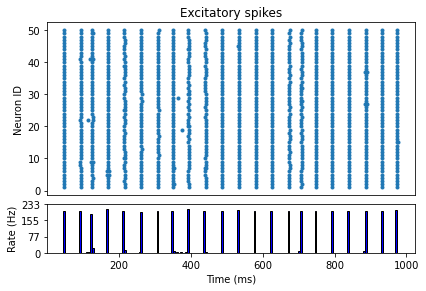

<Figure size 432x288 with 0 Axes>

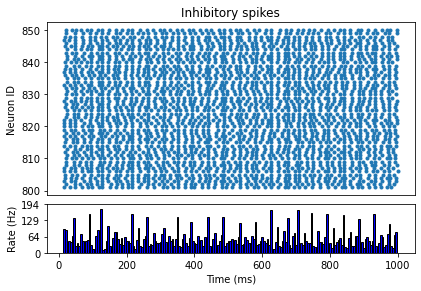

In [146]:
#Raster of exitatory
pylab.figure(1)
nest.raster_plot.from_device(espikes, hist=True)
pylab.title('Excitatory spikes')
#pylab.savefig('Exit_rast_hist_nest30.png')
plt.show()

#Raster of exitatory
pylab.figure(2)
nest.raster_plot.from_device(ispikes, hist=True)
pylab.title('Inhibitory spikes')
#pylab.savefig('Inibh_rast_hist_nest30.png')
plt.show()

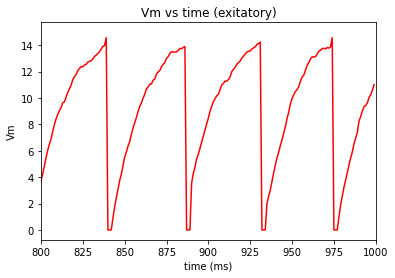

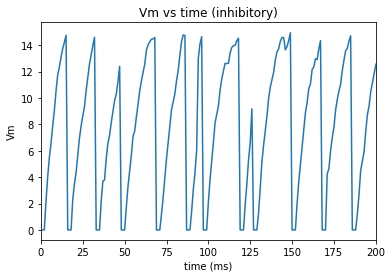

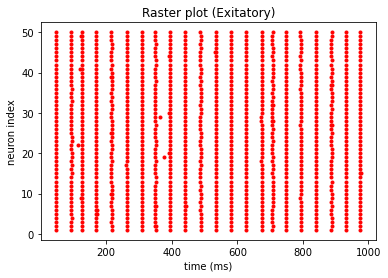

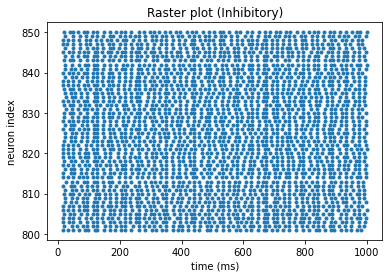

In [147]:
#We want to plot the membrane potential evolution of the neurons
#Vm FOR EXITATORY
dmm=nest.GetStatus(multimeter_e)[0] #the index 0 allow me to then visualize neuron 0, if you put 10 you observe neuron 10
#print(dmm)
Vms_e=dmm['events']["V_m"][::N_rec]# first index until the end ::
#After each 50 values I have the next V (at next time step) for that neuron 
#For each step i record 50 neurons)
#If I don't put 50 I have the 50 values of V for each step (because I have 50 neurons)

#print(Vms_e[0:100])
ts_e=dmm['events']['times'][::N_rec] #Same reasoning as before
#print(ts_e[0:100])

#Plot the figure for Vm for 1 exitatory neuron
pylab.figure(1)
pylab.plot(ts_e,Vms_e, color='r')
pylab.title('Vm vs time (exitatory)')
pylab.xlim(800,1000)
#pylab.xlim(0,200)
pylab.xlabel('time (ms)')
pylab.ylabel('Vm')
#pylab.savefig('Exit_memb_params.png')
pylab.show()



#Vm FOR INHIBITORY
dmm=nest.GetStatus(multimeter_i)[0]
#print(dmm)
Vms_i=dmm['events']['V_m'][::N_rec]# first index until the end, 2nd endtry for each 
ts_i=dmm['events']['times'][::N_rec]
pylab.figure(2)
pylab.plot(ts_i,Vms_i)
pylab.title('Vm vs time (inhibitory)')
pylab.xlabel('time (ms)')
pylab.xlim(0,200)
#pylab.xlim(800,1000)
pylab.ylabel('Vm')
#pylab.savefig('Inib_memb_params.png')
pylab.show()

#SPIKE COUNTER FOR EXITATORY
dsD_e=nest.GetStatus(espikes, keys='events')[0] #Here I access directly the dictionary with key eventnts of the first neuru[0]
evs_e=dsD_e['senders']
ts_e=dsD_e['times']

pylab.figure(3)
pylab.plot(ts_e,evs_e,'.',color='r')
pylab.title('Raster plot (Exitatory)')
pylab.xlabel('time (ms)')
pylab.ylabel('neuron index')
#pylab.savefig('Raster_Exit_params_nest30.png')
pylab.show()

#SPIKE COUNTER FOR INHIBITORY
dsD_i=nest.GetStatus(ispikes, keys='events')[0] #Here I access directly the dictionary with key eventnts of the first neuru[0]
evs_i=dsD_i['senders']
ts_i=dsD_i['times']

pylab.figure(4)
pylab.plot(ts_i,evs_i,'.')
pylab.title('Raster plot (Inhibitory)')
pylab.xlabel('time (ms)')
#pylab.xlim(0,100)
pylab.ylabel('neuron index')
pylab.savefig('Raster_Inib_params.png')
pylab.show()


# pylab.figure(5)
# pylab.plot(ts_e,evs_e,'.',color='g')
# pylab.plot(ts_i,evs_i,'.',color='g')
# pylab.title('Raster plot (Exitotory+Inhibitory)')
# pylab.xlabel('time (ms)')
# pylab.ylabel('neuron')
# #pylab.plot(ts2,evs2,'.')
# pylab.show()

# Analyse the network:

Try to change the input to the neurons. 
Instead of an input with Gaussian noise use a constant input.
What is the effect on the raster plots? \
Save the plots for each test you do. 

In [148]:
#Answer:

Why do you think the neurons synchronize?

In [149]:
#Answer:

What happens if your external input is higher? How this influence the firing rate of the neurons? Try to increase the external input in both cases (constant input and noise).

In [150]:
#Answer:

What is the overall behaviour of the excitatory population when the input is increased?

In [151]:
#Answer

What about the single neuron behaviour? Does it fire more? (Look at the Vm plots of 1 neuron and compare the two cases)

In [152]:
#Answer:

Now change the strenght of connections between the two groups.
What is the effect of each change in the network behaviour? Save the plots

In [153]:
#Answer:

What happens if Jei is too strong? Why is this happening?

In [138]:
#Answer: